In [3]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os

from crashpy.utilities import crashMemMap

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [4]:
def redshift_to_snap(redshift):
    correspondense = {6:'sn013', 8:'sn008', 10:'sn004'}
    return correspondense[redshift]

In [5]:
def halo_run_path(halo_id, redshift, setting):
    base_path = '/ptmp/mpa/mglatzle/TNG_f_esc'
    path_to_dir = os.path.join(base_path, setting, 'run', 'L35n2160TNG', redshift_to_snap(redshift), f'g{halo_id}')
    return path_to_dir

In [6]:
def get_simulation_paths(path_to_halo):
    path_out =  os.path.join(path_to_halo, 'Output/phys_ic00_rt05.out')
    return path_out

In [7]:
def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

In [8]:
def get_maps(halo_id, redshift, setting, return_prop, props=None):
    path_to_halo = halo_run_path(halo_id, redshift, setting)
    if props == None:
        props = ['T', 'xHI', 'xHII', 'xHeI', 'xHeII', 'xHeIII']
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    path_out = get_simulation_paths(path_to_halo) 
    halo_out = crashMemMap(path_out, 'all')
    
    maps = {}
    maps['out'] = {}

    for prop in props:
        if prop in prop_dict:
            maps['out'][prop] = halo_out[prop_dict[prop]]
        elif prop == 'xHI':
            maps['out'][prop] = get_H_map(halo_out)
        elif prop == 'xHeI':
            maps['out'][prop] = get_He_map(halo_out)
        else:
            raise ValueError(f'The property {prop} does not exist.')
    return maps['out'][return_prop]

In [9]:
def xHI_histogram(maps, prop, keys, title, log_scale=True,  bins=16, save=False):
    
    x_label = prop
    y_label = 'Number of cells'
    
    lower_bound = 0
    upper_bound = 1.000001
    narrowing_factor = 4.5 # For setting the bar widthin the plot
    
    labelsize = 50
    legendsize = 35
    axis_width = 4
    linewidth = 4
    tick_size_major = 16
    tick_size_minor = 8
    tick_width_major = 4
    tick_width_minor = 3
    tick_label_size = 35
    figsize_x = 20
    figsize_y = 15
    title_size = 65

    edges = np.linspace(lower_bound, upper_bound, bins)

    binning_width = edges[1]-edges[0]
    bar_width = binning_width/narrowing_factor

    heights = {}
    for i, key in enumerate(keys):
        heights[key], *_ = plt.hist(maps[key]+bar_width*(i-1), bins=edges+bar_width*(i-1), width = bar_width, 
                     label=f'{key}: <{prop}>={np.average(maps[key]):.5f}')
        
    if log_scale:
        plt.yscale('log')
    
    plt.title(title, fontsize=title_size)
    plt.rc('xtick', labelsize=tick_label_size) 
    plt.rc('ytick', labelsize=tick_label_size) 
    plt.xlabel(x_label, fontsize=labelsize)
    plt.ylabel(y_label, fontsize=labelsize)
    plt.rcParams["figure.figsize"] = (figsize_x,figsize_y)
    plt.rc('axes', linewidth=axis_width)
    plt.tick_params(length=tick_size_major, width=tick_width_major)
    plt.tick_params(length=tick_size_minor, width=tick_width_minor, which='minor')
    plt.legend(fontsize = legendsize)
    if save:
        if log_scale:
            plt.savefig(f'/u/ivkos/analysis/plots/xHI/halo_{halo_id}.pdf', bbox_inches = 'tight')
        else:
            plt.savefig(f'/u/ivkos/analysis/plots/xHI/halo_{halo_id}_lin.pdf', bbox_inches = 'tight')
    plt.show()
    return #ratio_height, ratio_fesc

In [10]:
def update_df(df):
    mult = 1e10/h
    df['StarMass']= df['HaloMass']*df['FractionStars']*mult
    return

In [11]:
conv5e6 = pd.read_pickle('dfs/conv5e6.pickle')
conv8e6 = pd.read_pickle('dfs/conv8e6.pickle')
conv1e7 = pd.read_pickle('dfs/conv1e7.pickle')
conv3e7 = pd.read_pickle('dfs/conv3e7.pickle')
conv5e7 = pd.read_pickle('dfs/conv5e7.pickle')
conv1e8 = pd.read_pickle('dfs/conv1e8.pickle')
conv1e9 = pd.read_pickle('dfs/conv1e9.pickle')
update_df(conv5e6)
update_df(conv8e6)
update_df(conv1e7)
update_df(conv3e7)
update_df(conv5e7)
update_df(conv1e8)
update_df(conv1e9)

In [12]:
merge_1 = conv5e6.merge(conv8e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_5e6', '_8e6'])
merge_2 = merge_1.merge(conv1e7[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_2.rename(columns={'f_esc':'f_esc_1e7'}, inplace=True)

merge_3 = merge_2.merge(conv3e7[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_3.rename(columns={'f_esc':'f_esc_3e7'}, inplace=True)

merge_4 = merge_3.merge(conv5e7[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_4.rename(columns={'f_esc':'f_esc_5e7'}, inplace=True)

merge_5 = merge_4.merge(conv1e8[['ID', 'z', 'f_esc']], on=['ID', 'z'])
merge_5.rename(columns={'f_esc':'f_esc_1e8'}, inplace=True)

comparison = merge_5.merge(conv1e9[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison.rename(columns={'f_esc':'f_esc_1e9'}, inplace=True)

In [86]:
def plot_convergence_comparison(comparison, labels=None, relative=False, both=False, save=False):
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 65
    legend_loc = 'upper right'
    fig_width = 40
    fig_height = 50
    axes_width = 3
    size = 600
    labelsize=110
    tick_labelsize = 75
    
    x_label = '$M_{\star} [\log(M_{\u2609})]$'
    
    if labels==None:
        labels=[r'$N_{\mathrm{p}}=5\times 10^6$', r'$N_{\mathrm{p}}=8\times 10^6$', r'$N_{\mathrm{p}}=10^7$', r'$N_{\mathrm{p}}=3\times 10^7$',
               r'$N_{\mathrm{p}}=5\times 10^7$', r'$N_{\mathrm{p}}=10^8$',r'$N_{\mathrm{p}}=10^9$']
    
    if both:
        f = plt.figure()
        plt.subplots_adjust(hspace=0.001)
        plt.subplots_adjust(wspace=0.001)
        ax1 = plt.subplot2grid((2, 1), (0,0))
        ax2 = plt.subplot2grid((2, 1), (1,0), sharex=ax1)
        
        y_label_1 = r'$f_{\mathrm{esc}}(N_{\mathrm{p}})$'
        y_label_2 = r'$\frac{f_{\mathrm{esc}}(N_{\mathrm{p}})-f_{\mathrm{esc}}(10^9)}{f_{\mathrm{esc}}(10^9)}$'
        ax1.scatter(comparison.StarMass, comparison.f_esc_5e6, s=size, marker='x', label=labels[0])
        #ax1.scatter(comparison.StarMass, comparison.f_esc_8e6, s=size, marker='+', label=labels[1])
        ax1.scatter(comparison.StarMass, comparison.f_esc_1e7, s=size, marker='o', label=labels[2])
        #ax1.scatter(comparison.StarMass, comparison.f_esc_3e7, s=size, marker='^', label=labels[3])
        ax1.scatter(comparison.StarMass, comparison.f_esc_5e7, s=size, marker='d', label=labels[4])
        ax1.scatter(comparison.StarMass, comparison.f_esc_1e8, s=size, marker='s', label=labels[5])
        ax1.scatter(comparison.StarMass, comparison.f_esc_1e9, s=size, marker='*', label=labels[6])
        ax1.set_ylim(0, 1.0)
        ax1.set_xscale('log')
        ax1.set_xlabel(x_label, size=labelsize)
        ax1.set_ylabel(y_label_1, size=labelsize)
        ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
        
        
        ax2.scatter(comparison.StarMass, (comparison.f_esc_5e6-comparison.f_esc_1e9)/comparison.f_esc_1e9, s=size, marker='x', label=labels[0])
        #ax2.scatter(comparison.StarMass, (comparison.f_esc_8e6-comparison.f_esc_1e9)/comparison.f_esc_1e9, s=size, marker='+', label=labels[1])
        ax2.scatter(comparison.StarMass, (comparison.f_esc_1e7-comparison.f_esc_1e9)/comparison.f_esc_1e9, s=size, marker='o', label=labels[2])
        #ax2.scatter(comparison.StarMass, (comparison.f_esc_3e7-comparison.f_esc_1e9)/comparison.f_esc_1e9, s=size, marker='^', label=labels[3])
        ax2.scatter(comparison.StarMass, (comparison.f_esc_5e7-comparison.f_esc_1e9)/comparison.f_esc_1e9, s=size, marker='d', label=labels[4])
        ax2.scatter(comparison.StarMass, (comparison.f_esc_1e8-comparison.f_esc_1e9)/comparison.f_esc_1e9, s=size, marker='s', label=labels[5])
        ax2.set_ylabel(y_label_2, size=labelsize)    
        ax2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
        ax2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
        ax2.set_xlabel(x_label, size=labelsize)
        lines_labels = [ax1.get_legend_handles_labels()]
        lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
        ax2.legend(lines, labels, fontsize=legend_fontsize)
        

    else:
        if relative:
            y_label = r'$f_{\mathrm{esc}}(N_{\mathrm{packets}})/f_{\mathrm{esc}}(10^9)}$'
            plt.scatter(comparison.StarMass, comparison.f_esc_5e6/comparison.f_esc_1e9, s=size, marker='x', label=labels[0])
            #plt.scatter(comparison.StarMass, comparison.f_esc_8e6/comparison.f_esc_1e9, s=size, marker='+', label=labels[1])
            plt.scatter(comparison.StarMass, comparison.f_esc_1e7/comparison.f_esc_1e9, s=size, marker='o', label=labels[2])
            #plt.scatter(comparison.StarMass, comparison.f_esc_3e7/comparison.f_esc_1e9, s=size, marker='^', label=labels[3])
            plt.scatter(comparison.StarMass, comparison.f_esc_5e7/comparison.f_esc_1e9, s=size, marker='d', label=labels[4])
            plt.scatter(comparison.StarMass, comparison.f_esc_1e8/comparison.f_esc_1e9, s=size, marker='s', label=labels[5])
        else:
            y_label = r'$f_{\mathrm{esc}}(N_{\mathrm{packets}})$'
            plt.scatter(comparison.StarMass, comparison.f_esc_5e6, s=size, marker='x', label=labels[0])
            #plt.scatter(comparison.StarMass, comparison.f_esc_8e6, s=size, marker='+', label=labels[1])
            plt.scatter(comparison.StarMass, comparison.f_esc_1e7, s=size, marker='o', label=labels[2])
            #plt.scatter(comparison.StarMass, comparison.f_esc_3e7, s=size, marker='^', label=labels[3])
            plt.scatter(comparison.StarMass, comparison.f_esc_5e7, s=size, marker='d', label=labels[4])
            plt.scatter(comparison.StarMass, comparison.f_esc_1e8, s=size, marker='s', label=labels[5])
            plt.scatter(comparison.StarMass, comparison.f_esc_1e9, s=size, marker='*', label=labels[6])
            
            plt.ylim(0, 1.0)
            plt.xlabel(x_label, size=labelsize)
            plt.ylabel(y_label, size=labelsize)
            plt.xscale('log')
            
            plt.legend(fontsize=legend_fontsize)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.xscale('log')
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    
    if save:
        path = f'/u/ivkos/analysis/plots/convergence_photons.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    
    plt.show()
    return

In [92]:
def plot_luminosity_convergence(comparison, labels=None, relative=False, save=False):
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 65
    legend_loc = 'upper right'
    fig_width = 40
    fig_height = 50
    axes_width = 3
    size = 1300
    labelsize=110
    tick_labelsize = 75
    
    x_label = '$M_{\star} [\log(M_{\u2609})]$'
    
    if labels==None:
        labels=['luminous sources', 'all sources']
    
        f = plt.figure()
        plt.subplots_adjust(hspace=0.001)
        plt.subplots_adjust(wspace=0.001)
        ax1 = plt.subplot2grid((2, 1), (0,0))
        ax2 = plt.subplot2grid((2, 1), (1,0), sharex=ax1)
        
    y_label_1 = r'$f_{\mathrm{esc}}$'
    y_label_2 = r'$\frac{f_{\mathrm{esc}}(\mathrm{lum})-f_{\mathrm{esc}}(\mathrm{all})}{f_{\mathrm{esc}}(\mathrm{all})}$'
    ax1.scatter(comparison.StarMass, comparison.f_esc_lum, s=size, marker='x', label=labels[0])
    ax1.scatter(comparison.StarMass, comparison.f_esc_all, s=size, marker='+', label=labels[1])
    ax1.set_ylim(0, 1.0)
    ax1.set_xscale('log')
    ax1.set_xlabel(x_label, size=labelsize)
    ax1.set_ylabel(y_label_1, size=labelsize)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.set(xlabel=None)
    ax1.legend(fontsize=legend_fontsize)


    ax2.scatter(comparison.StarMass, (comparison.f_esc_lum-comparison.f_esc_all)/comparison.f_esc_all, s=size, marker='x', label=labels[0])
    ax2.set_ylabel(y_label_2, size=labelsize)    
    ax2.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax2.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax2.set_xlabel(x_label, size=labelsize)
    ax2.set_ylim(-0.029,0.029)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.xscale('log')
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    
    if save:
        path = f'/u/ivkos/analysis/plots/convergence_luminosity.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    
    plt.show()
    return

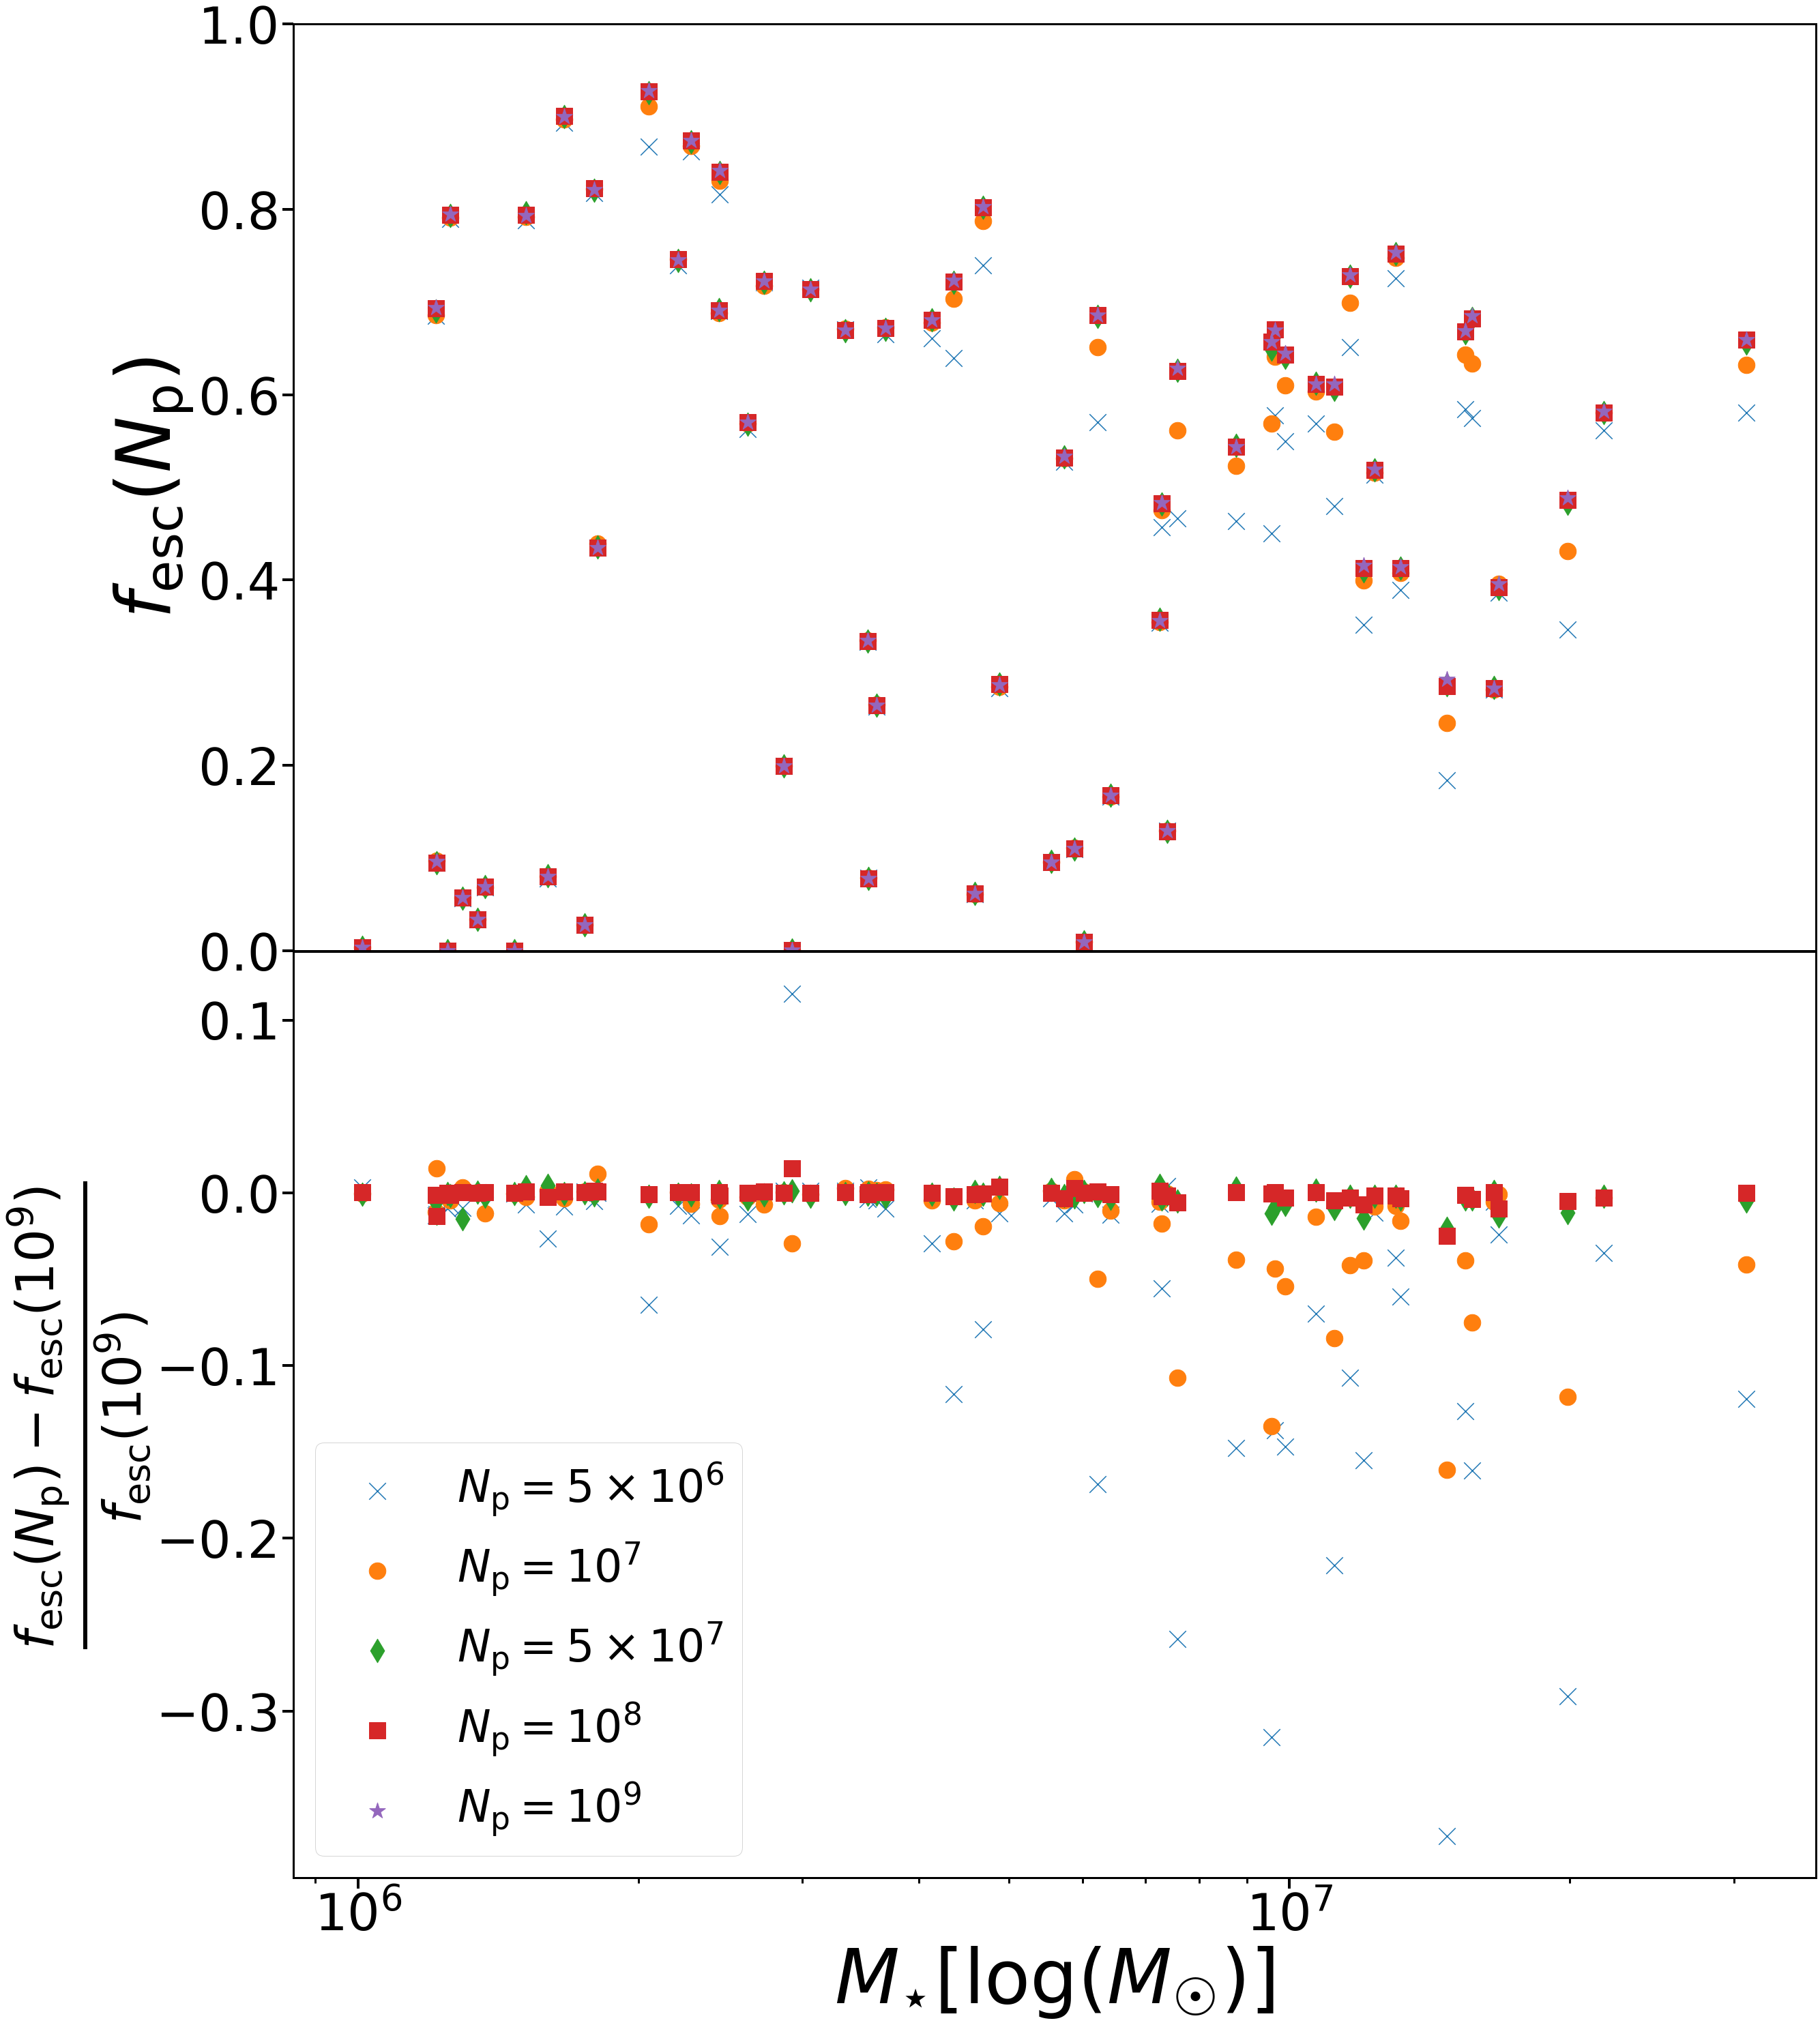

In [88]:
plot_convergence_comparison(comparison, relative=False, both=True, save=True)

In [82]:
df_all = pd.read_pickle('dfs/all_sources.pickle')
update_df(df_all)
df_lum = pd.read_pickle('dfs/esc_analysis_updated.pickle')
update_df(df_lum)

In [83]:
comparison_lum = df_all.merge(df_lum[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_all', '_lum'])

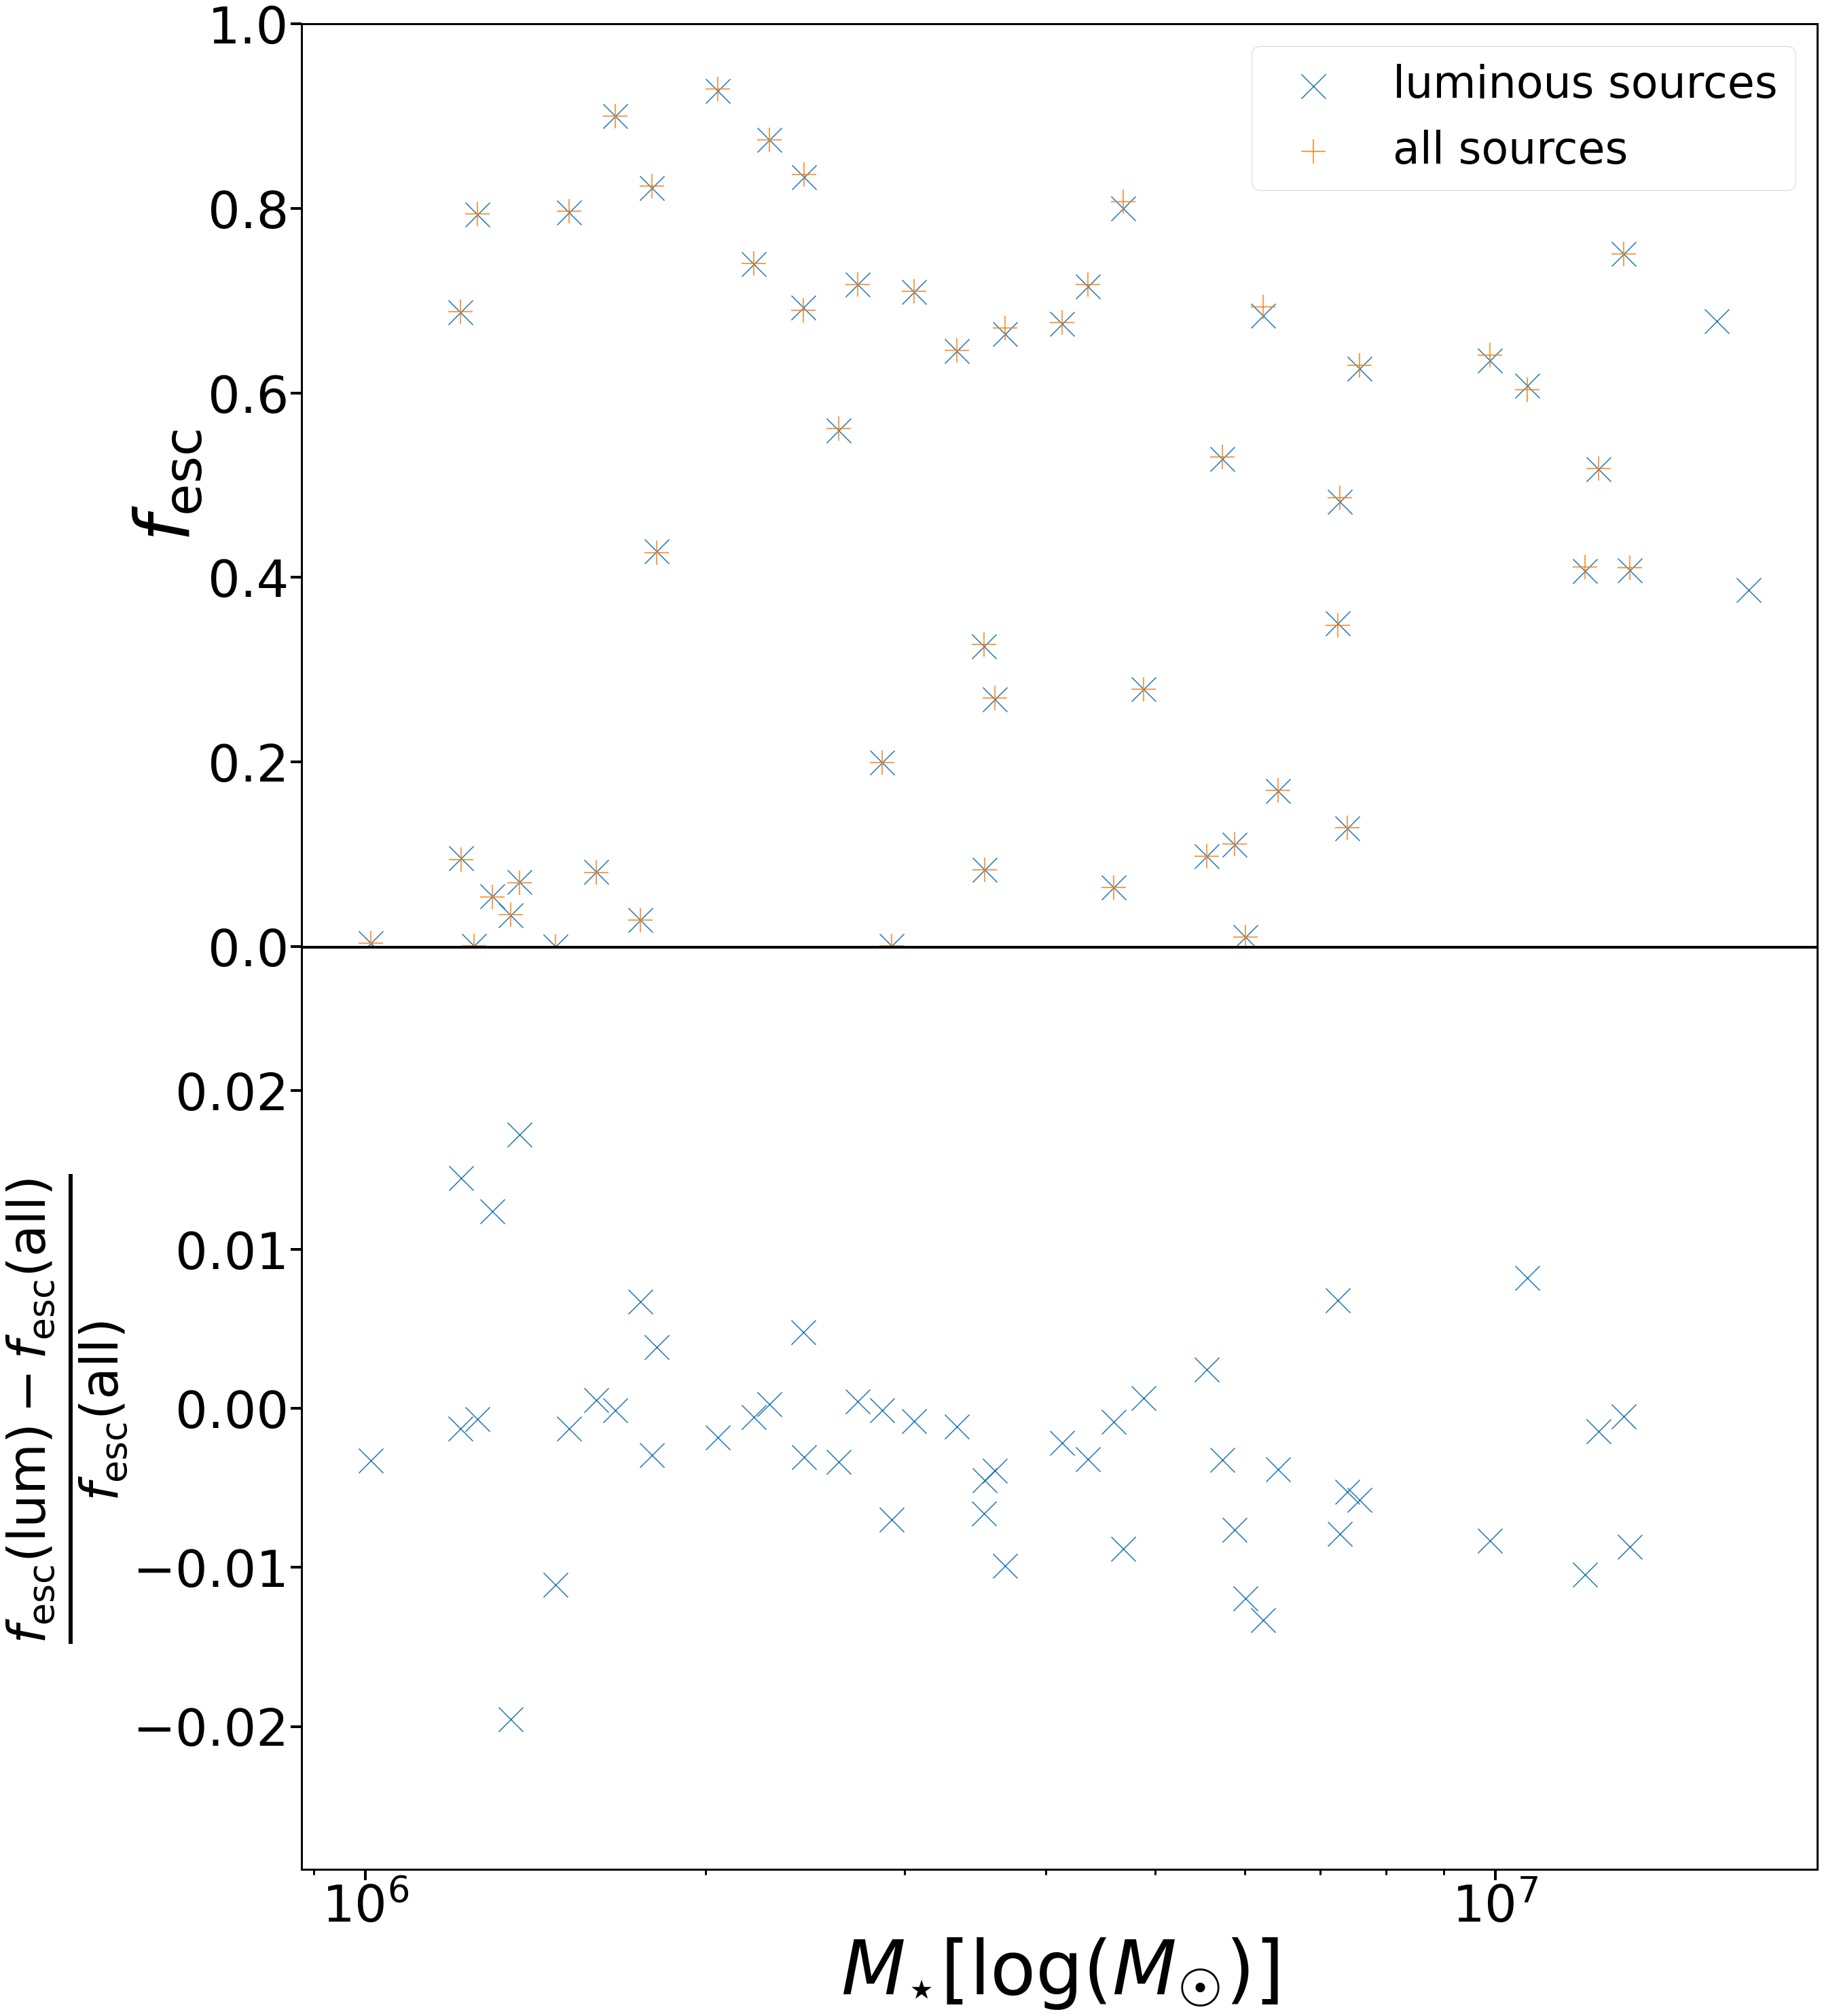

In [94]:
plot_luminosity_convergence(comparison_lum, labels=None, relative=False, save=True)

In [9]:
conv5e6 = pd.read_pickle('dfs/conv5e6.pickles')
merge_1 = df_1e5_full.merge(df_1e6[['ID', 'z', 'f_esc']], on=['ID', 'z'], suffixes=['_1e5', '_1e6'])
comparison_df = merge_1.merge(df_1e4_full[['ID', 'z', 'f_esc']], on=['ID', 'z'])
comparison_df['f_esc_1e4'] = comparison_df['f_esc']
update_df(comparison_df)

In [155]:
def galaxy_cutout(prop_map):
    #return prop_map[20:60,27:50,30:70]
    return prop_map[:10,:10,:10]

In [181]:
settings = ['full_esc', 'new_numerical_5e6']
keys = ['1e5', '5e6']
ID = 1029
z = 8
maps = {}
return_prop = 'xHeIII'

for i, setting in enumerate(settings):
    prop_map = get_maps(ID, z, setting, return_prop=return_prop)
    #prop_map = galaxy_cutout(prop_map)
    prop_map = prop_map.flatten()
    maps[keys[i]] = prop_map

In [236]:
settings = ['full_esc', 'new_numerical_5e6', 'source_cells_ionized_1e5', 'source_cells_ionized_1e6']
keys = ['not ionized 1e5', 'not ionized 5e6', 'ionized 1e5', 'ionized 1e6']
ID = 1029
z = 8
maps = {}
return_prop = 'xHII'

for i, setting in enumerate(settings):
    prop_map = get_maps(ID, z, setting, return_prop=return_prop)
    #prop_map = galaxy_cutout(prop_map)
    prop_map = prop_map.flatten()
    maps[keys[i]] = prop_map

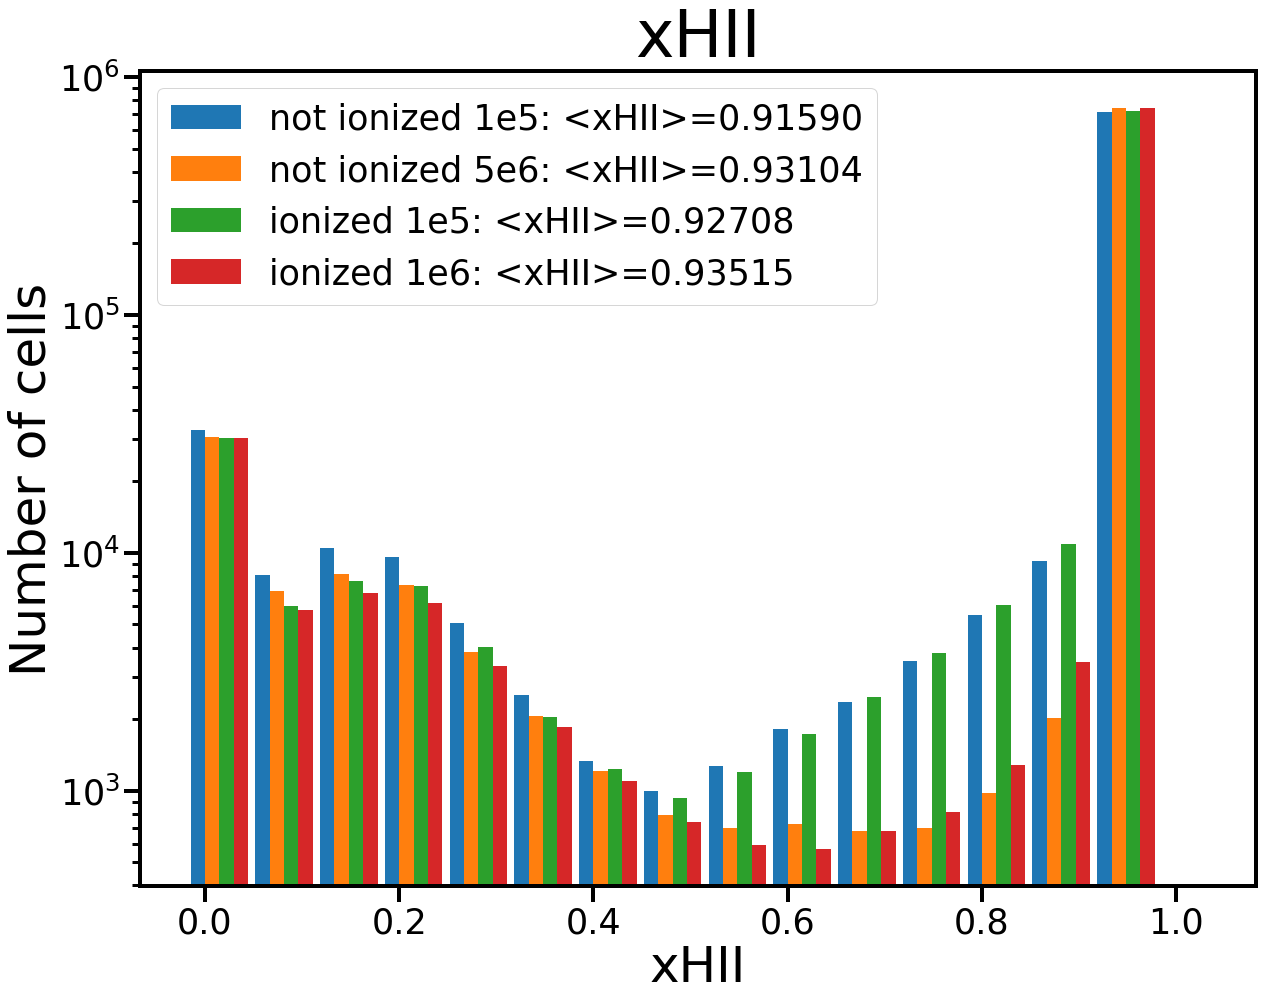

In [237]:
xHI_histogram(maps=maps, prop=return_prop, keys=keys, title=return_prop, log_scale=True,  bins=16, save=False)

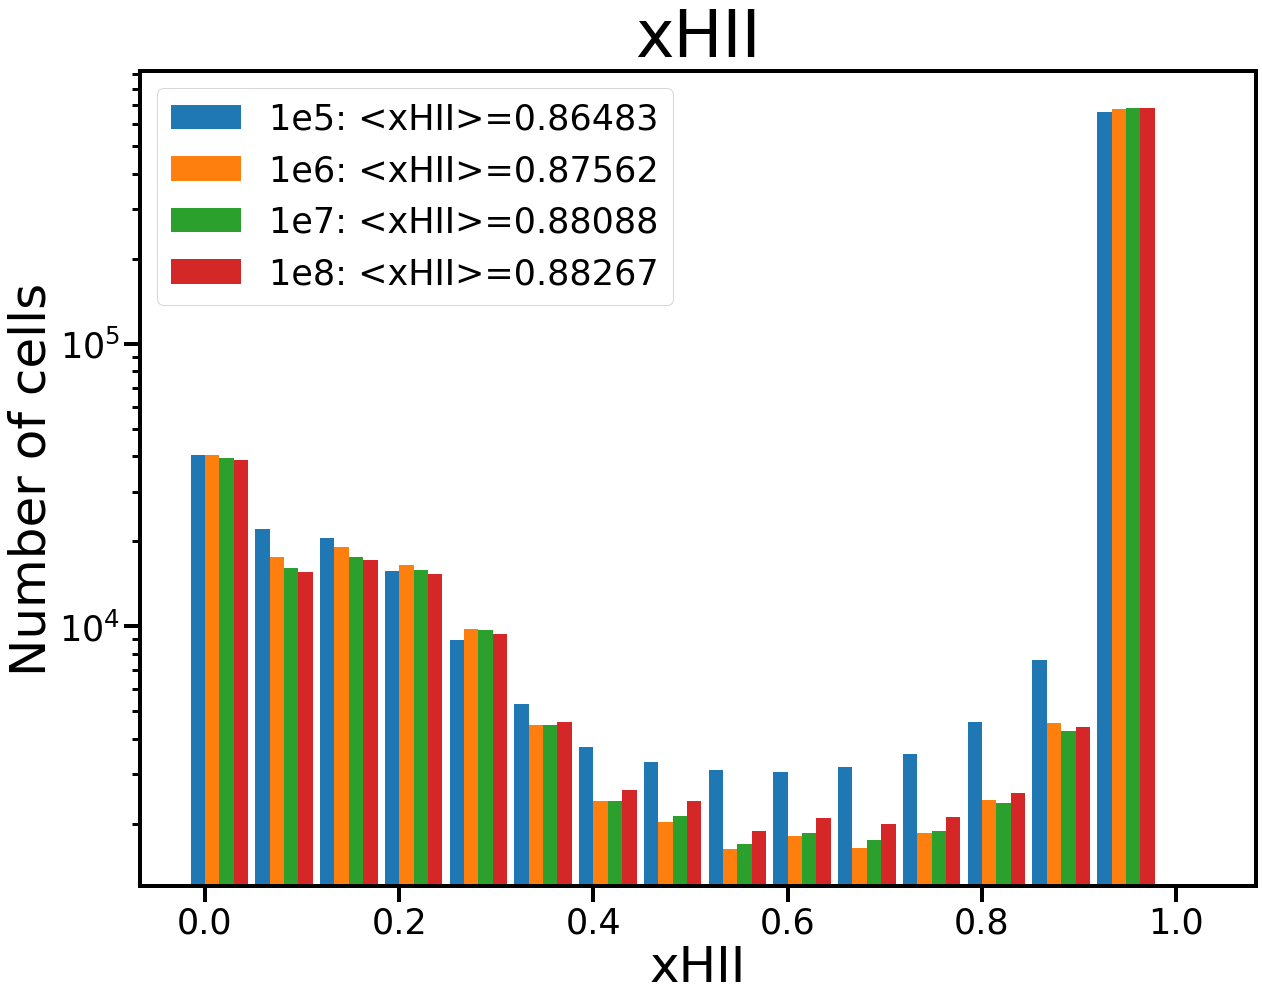

In [186]:
xHI_histogram(maps=maps, prop=return_prop, keys=keys, title=return_prop, log_scale=True,  bins=16, save=False)

In [72]:
df_1e5 = pd.read_pickle('dfs/full_esc.pickle')
df_5e6 = pd.read_pickle('dfs/new_numerical_5e6.pickle')

In [ ]:
keys = ['1e5','5e6']
#settings = ['numerical_1e4', 'fid2', 'numerical_1e6']
keys = ['1e4', '1e5', '1e6']
rel_heights = []
rel_fesc = []
z=8
ID = 10
for _,row in comparison_df.iterrows():
    maps = {}
    for i, setting in enumerate(keys):
HI_map_1e5 = get_maps(row.ID, row.z, setting, just_HI=True)
HI_map_1e5 = get_maps(row.ID, row.z, setting, just_HI=True)
        HI_map = HI_map.flatten()
        maps[keys[i]] = HI_map
    ratio_height, ratio_fesc = xHI_histogram(xHI_maps = maps, row=row, log_scale=False, bins=16, save=False)
    rel_heights.append(ratio_height)
    rel_fesc.append(ratio_fesc)

In [34]:
settings = ['numerical_1e4', 'fid2', 'numerical_1e6']
keys = ['1e4', '1e5', '1e6']
rel_heights = []
rel_fesc = []
for _,row in comparison_df.iterrows():
    maps = {}
    for i, setting in enumerate(settings):
        HI_map = get_maps(row.ID, row.z, setting, just_HI=True)
        HI_map = HI_map.flatten()
        maps[keys[i]] = HI_map
    ratio_height, ratio_fesc = xHI_histogram(xHI_maps = maps, row=row, log_scale=False, bins=16, save=False)
    rel_heights.append(ratio_height)
    rel_fesc.append(ratio_fesc)

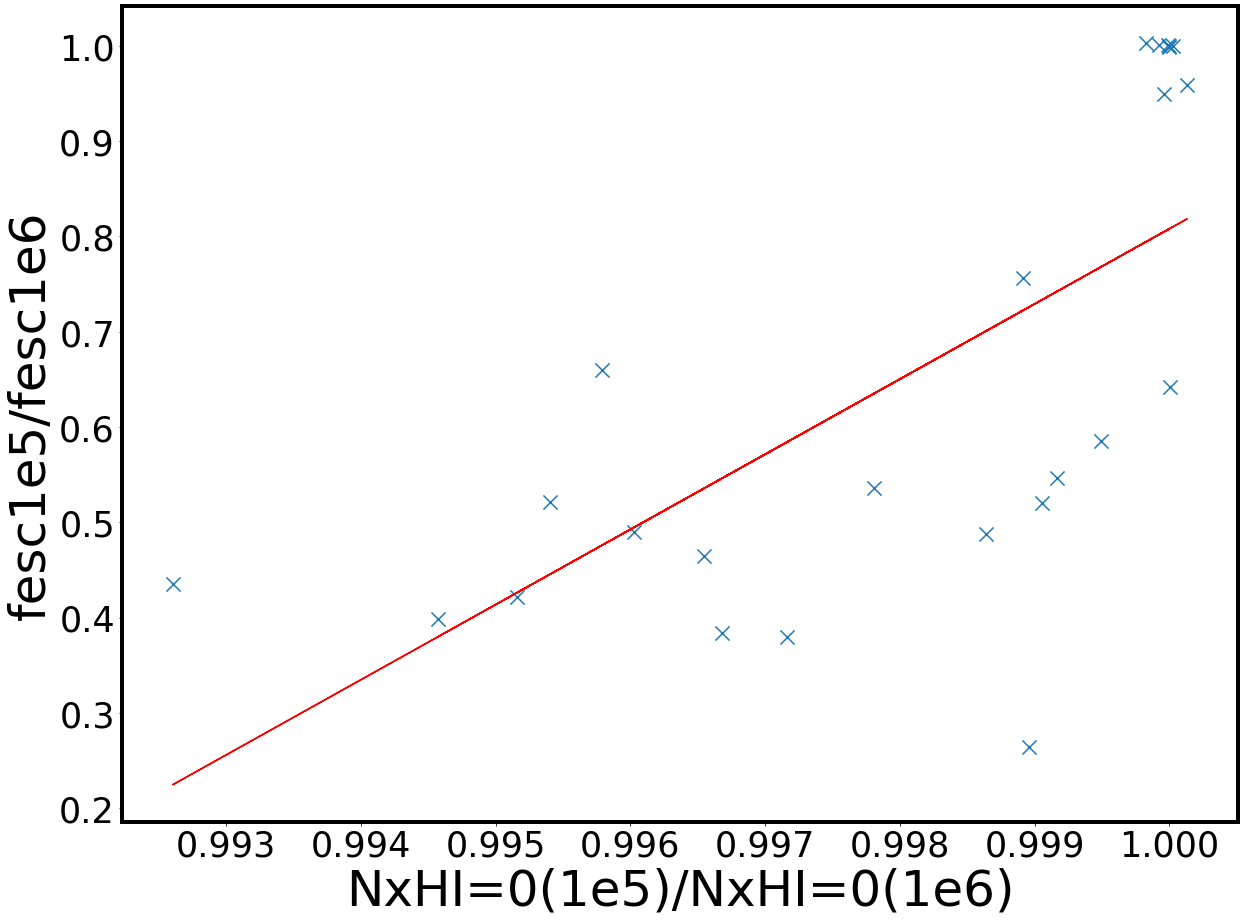

In [44]:
plt.scatter(rel_heights, rel_fesc, s=200, marker='x')
m, b = np.polyfit(rel_heights, rel_fesc, 1)
plt.plot(rel_heights, m*np.array(rel_heights) + b, color='red')
plt.ylabel('fesc1e5/fesc1e6', fontsize=50)
plt.xlabel('NxHI=0(1e5)/NxHI=0(1e6)', fontsize=50);

In [210]:
halo_dir = '/ptmp/mpa/mglatzle/TNG_f_esc/fid2/input/L35n2160TNG/sn008/g1029'
sources_path = os.path.join(halo_dir, 'sources_ic00.in')

In [204]:
from crashpy.utilities import crashMemMap

In [214]:
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c',
'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']

sources = pd.read_table(sources_path, delimiter='\t', names=column_names)

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [90]:
path_to_halos = '/ptmp/mpa/mglatzle/TNG_f_esc/mer8_cor/input/L35n2160TNG/sn008'
halos = ['g1', 'g100', 'g111', 'g1029']
source_file = 'sources_ic00.in'
column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c', 'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']

In [98]:
lum_sum/lum_sum[-1]

array([0.96679315, 0.98026508, 0.99300753, 0.99686908, 1.        ])

In [61]:
sources_path = '/ptmp/mpa/mglatzle/TNG_f_esc/524_1029/input/L35n2160TNG/sn008/g1029/sources_ic00.in'
sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
initial_lum = sources['Q'].str.replace('d','e').astype('float')

In [77]:
merge_radii = [0, 1.9, 5, 10]
lum_threshold = [0,0.001, 0.005, 0.01, 0.05]
threshold_fesc = [0.294, 0.293, 0.290, 0.303]

In [11]:
def all_stroemgren_rad(config):
    base_path = '/ptmp/mpa/mglatzle/TNG_f_esc'
    input_path = 'input/L35n2160TNG'
    run_path = 'run/L35n2160TNG'
    config_path = os.path.join(base_path, config)
    input_path = os.path.join(config_path, input_path)
    run_path = os.path.join(config_path, run_path)
    snaps = ['sn004', 'sn008', 'sn013']
    column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c', 'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']

    radius = 5.
    stroemgren = []
    luminosities = []
    for snap in snaps:
        snap_path = os.path.join(input_path, snap)
        run_snap_path = os.path.join(run_path, snap)
        for halo in os.listdir(snap_path):
            if halo.startswith('g'):
                
                halo_path = os.path.join(snap_path, halo)
                halo_run_path = os.path.join(run_snap_path, halo)
                source_name = 'sources_ic00.in'
                sources_path = os.path.join(halo_path, source_name)
                sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
                initial_lum = sources['Q'].str.replace('d','e').astype('float')
                
                try:
                    sim = Sim(halo_run_path)
                except:
                    print(halo_run_path)
                    continue

                coordinates = np.array([sources.x, sources.y, sources.z])
                coord = coordinates.T
                lum = np.array(initial_lum) 
                luminosities.extend(lum)
            
                ic = sim.ICs['00']
                halo_maps = crashMemMap(dens_path, 'all')
                density_maps = {}
                density_maps['H'] = ic.getHDensity()
                density_maps['T'] = halo_maps[0]
                cell_size_cm = get_cell_size_cm(ic)
                
                for i in range(len(lum)):
                    densities = density_maps['H']
                    temperature = density_maps['T']
                    source_pos = coord[i]
                    luminosity=lum[i]*1e52
                    density, temperature = average_quantities(source_pos, radius, densities, temperature)
                    stroem_rad = stroemgren_rad(density, temperature, luminosity)/cell_size
                    stroemgren.append(stroem_rad)
    return luminosities, stroemgren

In [15]:
def luminosities_counts(setting_dir):
    base_path = '/ptmp/mpa/mglatzle/TNG_f_esc/luminosity_analysis'
    snaps = ['sn004', 'sn008', 'sn013']
    setting_path = os.path.join(base_path, setting_dir)
    setting_dict = {}
    column_names=['x', 'y', 'z', 'a', 'Q', 'b', 'name', 'c', 'halo', 'd', 'packets', 'e', 'loc_uv', 'f', 'loc_x']

    for subsetting in os.listdir(setting_path):
        subsetting_path=os.path.join(setting_path, subsetting, 'L35n2160TNG')
        count= 0
        luminosities = 0
        for snap in snaps:
            snap_path = os.path.join(subsetting_path, snap)
            for halo in os.listdir(snap_path):
                if halo.startswith('g'):

                    halo_path = os.path.join(snap_path, halo)
                    source_name = 'sources_ic00.in'
                    sources_path = os.path.join(halo_path, source_name)
                    sources = pd.read_table(sources_path, delimiter='\t', names=column_names)
                    initial_lum = sources['Q'].str.replace('d','e').astype('float')

                    lum = np.array(initial_lum)*1e52
                    luminosities += lum.sum()
                    count += len(lum)
            setting_dict[subsetting] = (luminosities, count)

    return setting_dict

In [18]:
rad_5_dict = luminosities_counts('rad_5') 
rad_10_dict = luminosities_counts('rad_10') 
global_cutoff_dict = luminosities_counts('global_cutoff')

In [20]:
global_cutoff_dict = luminosities_counts('global_cutoff')

In [21]:
rad_5_dict
rad_10_dict
global_cutoff_dict

{'input_5e-2': (4.7763335547999976e+54, 1008),
 'input_1e-4': (4.886453180751997e+54, 10914),
 'input_5e-3': (4.8629519673100014e+54, 2021),
 'input_5e-4': (4.8809018149959994e+54, 5138),
 'input_1e-3': (4.875783381355002e+54, 3545),
 'input_1e-2': (4.851604740760001e+54, 1645),
 'input_all': (4.887959382066e+54, 24121)}

{'input_5e-2': (4.8411280214999996e+54, 1008),
 'input_1e-4': (4.887160841451998e+54, 10914),
 'input_5e-3': (4.8765250762099986e+54, 2021),
 'input_5e-4': (4.884397754796001e+54, 5138),
 'input_1e-3': (4.8824312727150004e+54, 3545),
 'input_1e-2': (4.8723154204599996e+54, 1645),
 'input_all': (4.887959382066e+54, 24121)}

{'input_5e-2': (4.770337999999999e+54, 892),
 'input_1e-4': (4.8864696359999983e+54, 10444),
 'input_5e-3': (4.861412380000001e+54, 1787),
 'input_5e-4': (4.880911288e+54, 4692),
 'input_1e-3': (4.875538279999999e+54, 3089),
 'input_1e-2': (4.850337799999999e+54, 1461),
 'input_all': (4.887959382066e+54, 24121)}

In [25]:
rad_5_dict.keys()

dict_keys(['input_5e-2', 'input_1e-4', 'input_5e-3', 'input_5e-4', 'input_1e-3', 'input_1e-2', 'input_all'])

In [35]:
y_rad_5_lum = []
y_rad_10_lum = []
y_global_lum = []

y_rad_5_count = []
y_rad_10_count = []
y_global_count = []
keys = ['input_1e-4', 'input_5e-4', 'input_1e-3', 'input_5e-3', 'input_1e-2', 'input_5e-2']
for key in keys:
    y_rad_5_lum.append(rad_5_dict[key][0]/rad_5_dict['input_all'][0])
    y_rad_10_lum.append(rad_10_dict[key][0]/rad_10_dict['input_all'][0])
    y_global_lum.append(global_cutoff_dict[key][0]/global_cutoff_dict['input_all'][0])
    
    y_rad_5_count.append(rad_5_dict[key][1]/rad_5_dict['input_all'][1])
    y_rad_10_count.append(rad_10_dict[key][1]/rad_10_dict['input_all'][1])
    y_global_count.append(global_cutoff_dict[key][1]/global_cutoff_dict['input_all'][1])

In [39]:
y_global_lum
y_global_count

[0.9996952212672905,
 0.9985580702466842,
 0.9974588368897715,
 0.9945688987998959,
 0.992303213033227,
 0.9759365058356344]

[0.43298370714315326,
 0.19451929853654493,
 0.12806268396832635,
 0.07408482235396542,
 0.06056962812487045,
 0.036980224700468474]

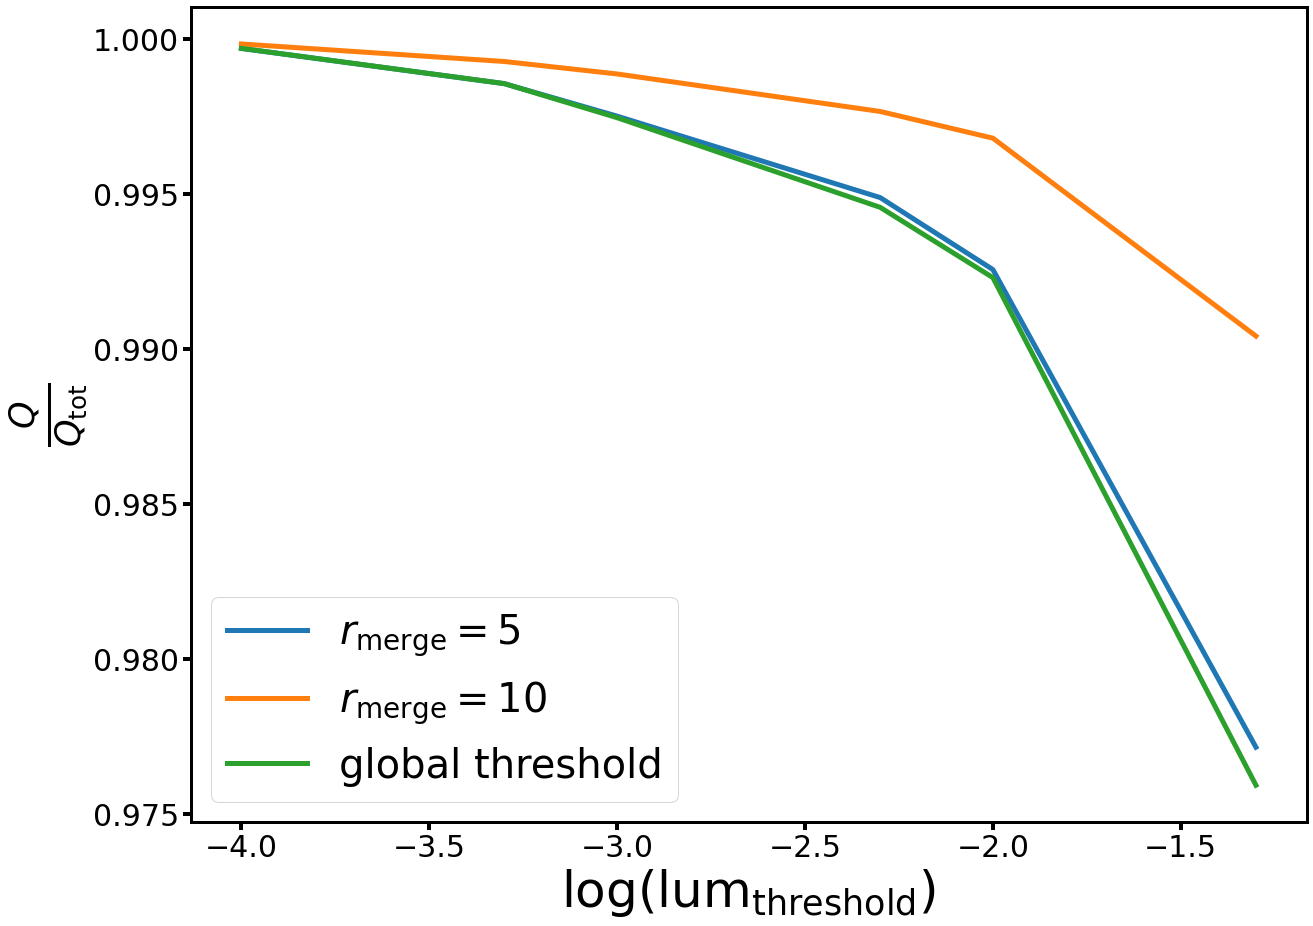

In [43]:
x_values = [-4, -3.3, -3, -2.3, -2,-1.3]
plt.plot(x_values, y_rad_5_lum, linewidth=5, label=r'$r_\mathrm{merge}=5$')
plt.plot(x_values, y_rad_10_lum, linewidth=5, label=r'$r_\mathrm{merge}=10$')
plt.plot(x_values, y_global_lum, linewidth=5, label='global threshold')
#plt.xscale('symlog', linthresh=0.001)
x_label = r'$\log(\mathrm{lum}_\mathrm{threshold})$'
y_label = r'$\frac{Q}{Q_\mathrm{tot}}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=40)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

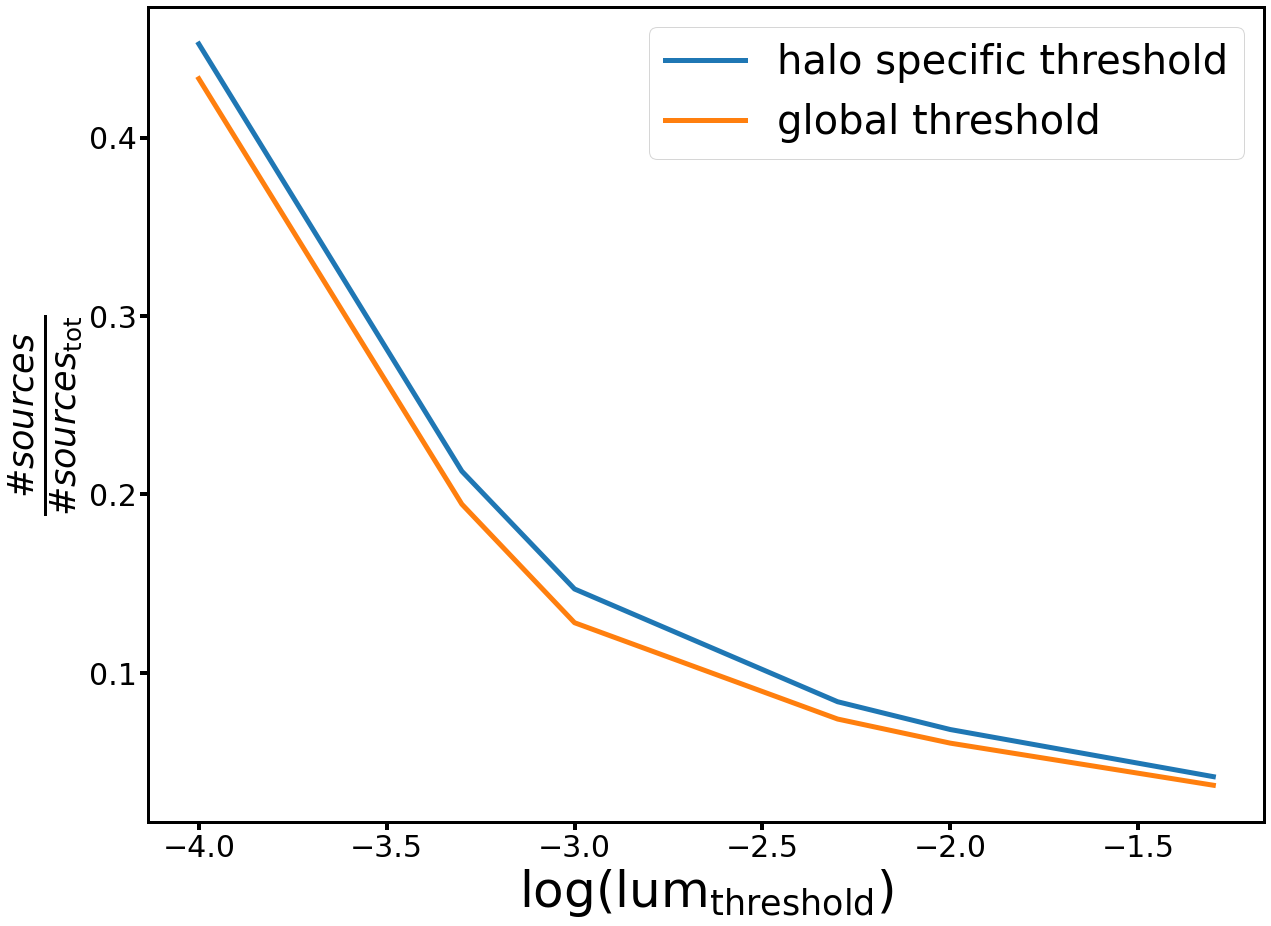

In [50]:
x_values = [-4, -3.3, -3, -2.3, -2,-1.3]
plt.plot(x_values, y_rad_5_count, linewidth=5, label=r'halo specific threshold')
#plt.plot(x_values, y_rad_10_count, linewidth=5, label=r'$r_\mathrm{merge}=10$')
plt.plot(x_values, y_global_count, linewidth=5, label='global threshold')
#plt.xscale('symlog', linthresh=0.001)
x_label = r'$\log(\mathrm{lum}_\mathrm{threshold})$'
y_label = r'$\frac{\# sources}{\# sources_\mathrm{tot}}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
plt.legend(fontsize=40)
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15);

In [58]:
tot_lum_sources = []
for element in sources:
    tot_lum_sources.append(element.sum())

In [36]:
tot_lum = []
for element in lum_ar:
    tot_lum.append(element.sum())

In [66]:
temp = []
temp.append(initial_lum.sum())
for element in tot_lum_sources:
    temp.append(element)
tot_lum_sources = temp

In [67]:
plt.plot(lum_threshold, (tot_lum_sources-tot_lum_sources[0])/tot_lum_sources[0], linewidth=5)
plt.xscale('symlog', linthresh=0.001)
x_label = 'threshold'
y_label = r'$\frac{Q(\mathrm{threshold})-Q_\mathrm{tot}}{Q_\mathrm{tot}}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15)

[1.4942182769999999, 1.4856844000000002, 1.470134, 1.4647299999999999, 1.38111]

In [100]:
tot_lum_sources/tot_lum_sources[0]

array([1.        , 0.99428873, 0.98388169, 0.98026508, 0.92430271])

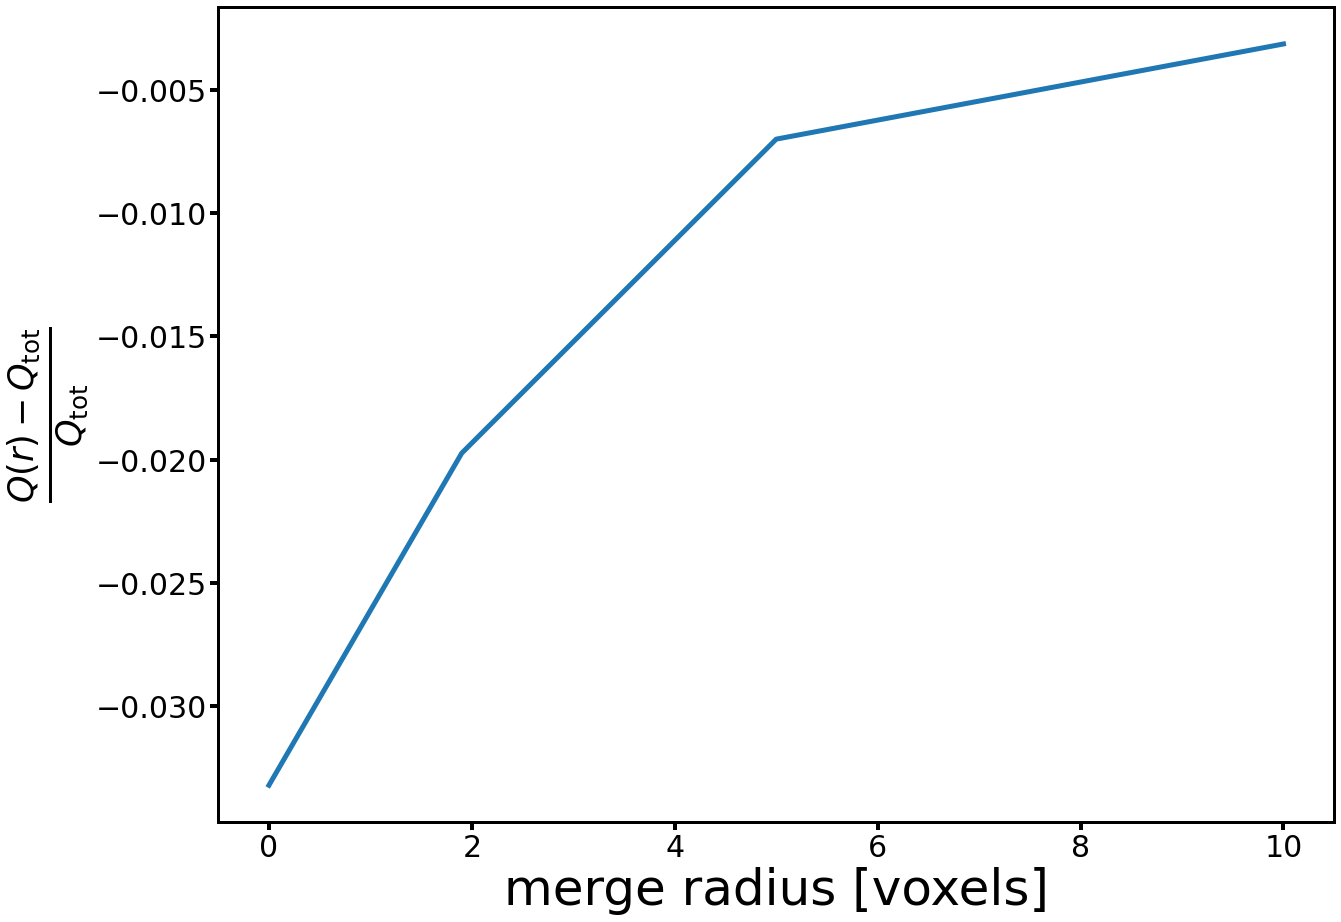

In [103]:
plt.plot(merge_radii, (lum_sum[:-1]-lum_sum[-1])/lum_sum[-1], linewidth=5)
#plt.xscale('symlog', linthresh=0.001)
x_label = 'merge radius [voxels]'
y_label = r'$\frac{Q(r)-Q_\mathrm{tot}}{Q_\mathrm{tot}}$'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15)

In [89]:
num

[121, 26, 9, 7, 4]

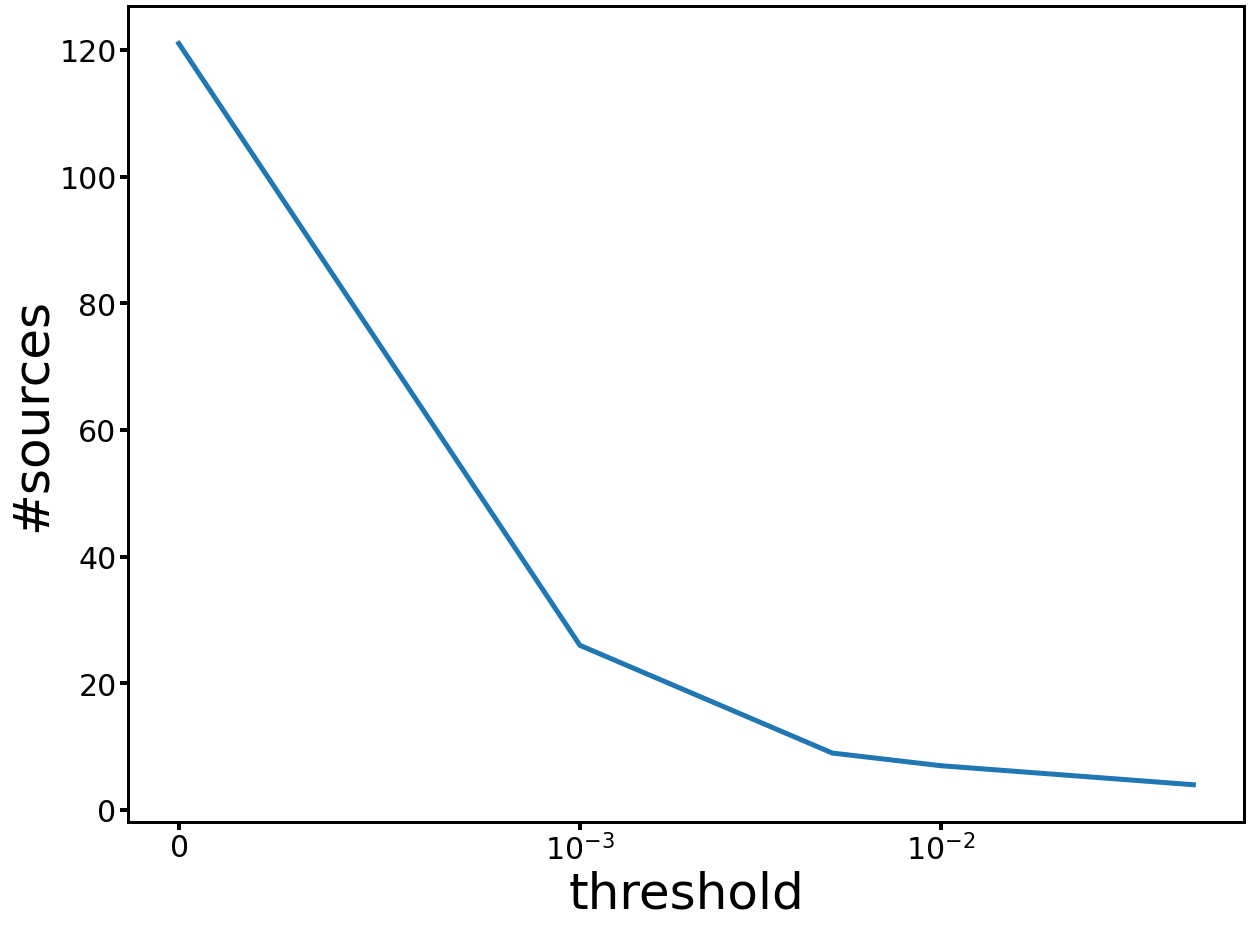

In [87]:
plt.plot(lum_threshold, num, linewidth=5)
plt.xscale('symlog', linthresh=0.001)
x_label = 'threshold'
y_label = r'#sources'
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30) 
plt.xlabel(x_label, fontsize=50)
plt.ylabel(y_label, fontsize=50)
plt.rc('axes', linewidth=3)
plt.tick_params(length=8, width=4)
plt.tick_params(length=4, width=2, which='minor')
#plt.yscale('log')
plt.rcParams["figure.figsize"] = (20, 15)